## Introduction & Data Cleaning 


In [1]:
# Importing necessay packages

sc.stop()
import sys
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import format_string
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col, avg
from pyspark.sql import functions as F
                             
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.classification import SVMWithSGD
from pyspark.sql.functions import length
from pyspark.sql import DataFrame
!HADOOP_LIBPATH='/opt/cloudera/parcels/CDH/lib'
!HADOOP_STREAMING='hadoop-mapreduce/hadoop-streaming.jar'

!alias hfs="$HADOOP_EXE fs"

sc = SparkContext()
spark = SparkSession(sc)


%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [2]:
# Unzipping the Dataset zip file

!rm -r *.csv
!unzip './the-movies-dataset.zip'
!hadoop fs -rm -r credits.csv
#!hadoop fs -put keywords.csv
!hadoop fs -rm -r links.csv
!hadoop fs -rm -r links_small.csv
!hadoop fs -rm -r movies_metadata.csv
!hadoop fs -rm -r ratings.csv
!hadoop fs -rm -r ratings_small.csv



!hadoop fs -put credits.csv
#!hadoop fs -put keywords.csv
!hadoop fs -put links.csv
!hadoop fs -put links_small.csv
!hadoop fs -put movies_metadata.csv
!hadoop fs -put ratings.csv
!hadoop fs -put ratings_small.csv


Archive:  ./the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       
20/05/13 11:28:00 INFO fs.TrashPolicyDefault: Moved: 'hdfs://dumbo/user/bns332/credits.csv' to trash at: hdfs://dumbo/user/bns332/.Trash/Current/user/bns332/credits.csv
20/05/13 11:28:02 INFO fs.TrashPolicyDefault: Moved: 'hdfs://dumbo/user/bns332/links.csv' to trash at: hdfs://dumbo/user/bns332/.Trash/Current/user/bns332/links.csv
20/05/13 11:28:04 INFO fs.TrashPolicyDefault: Moved: 'hdfs://dumbo/user/bns332/links_small.csv' to trash at: hdfs://dumbo/user/bns332/.Trash/Current/user/bns332/links_small.csv
20/05/13 11:28:06 INFO fs.TrashPolicyDefault: Moved: 'hdfs://dumbo/user/bns332/movies_metadata.csv' to trash at: hdfs://dumbo/user/bns332/.Trash/Current/user/bns332/movies_metadata.csv
20/

In [3]:
# Reading Movies Metadata file to a spark dataframe

df_movies_metadata = spark.read.format("csv").option("header","true").load("movies_metadata.csv")

df_movies_metadata.head()


Row(adult='False', belongs_to_collection="{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}", budget='30000000', genres="[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]", homepage='http://toystory.disney.com/toy-story', id='862', imdb_id='tt0114709', original_language='en', original_title='Toy Story', overview="Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.", popularity='21.946943', poster_path='/rhIRbceoE9lR4veEXuwCC2wARtG.jpg', production_companies="[{'name': 'Pixar Animation Studios', 'id': 3}]", production_countries="[{'iso_3166_1': 'US', 'name': 'United States of America'}]", releas

In [4]:
# Columns of Movies-Metadata

df_movies_metadata.columns

['adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

In [5]:
# Number of Entries in Movies-meta data

print("Number of Entries in Meta data dataframe:",df_movies_metadata.count())

Number of Entries in Meta data dataframe: 45572


In [6]:
# Column datatypes of movies_metadata dataframe

df_movies_metadata.describe()

DataFrame[summary: string, adult: string, belongs_to_collection: string, budget: string, genres: string, homepage: string, id: string, imdb_id: string, original_language: string, original_title: string, overview: string, popularity: string, poster_path: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, spoken_languages: string, status: string, tagline: string, title: string, video: string, vote_average: string, vote_count: string]

In [7]:
# Data Cleaning

# Dropping Unnecessary columns (imdb_id)

df_movies_metadata = df_movies_metadata.drop("imdb_id")

# Removing original_title and retaining the translated title

df_movies_metadata.select(["original_title","title"]).show(10)

df_movies_metadata = df_movies_metadata.drop("original_title")

+--------------------+--------------------+
|      original_title|               title|
+--------------------+--------------------+
|           Toy Story|           Toy Story|
|             Jumanji|             Jumanji|
|    Grumpier Old Men|    Grumpier Old Men|
|   Waiting to Exhale|[{'iso_639_1': 'e...|
|Father of the Bri...|Father of the Bri...|
|                Heat|                Heat|
|             Sabrina|             Sabrina|
|        Tom and Huck|        Tom and Huck|
|        Sudden Death|        Sudden Death|
|           GoldenEye|           GoldenEye|
+--------------------+--------------------+
only showing top 10 rows



In [8]:
# Presence of Zero-revenue movies
print("Before replacing Zero values")
df_movies_metadata.select("revenue","budget").show()

print("Number of Movie records with Revenue as 0")
print(df_movies_metadata.filter(df_movies_metadata.revenue=='0').count())

print("After replacing Zero values")
df_movies_metadata = df_movies_metadata.withColumn("revenue", df_movies_metadata["revenue"].cast(IntegerType()))
df_movies_metadata = df_movies_metadata.withColumn("revenue", F.when(F.col("revenue").isNull(), np.nan).otherwise(F.col("revenue")))
df_movies_metadata = df_movies_metadata.withColumn("revenue", F.when(F.col("revenue")=='0', np.nan).otherwise(F.col("revenue")))
df_movies_metadata.select(["revenue","budget"]).show()

Before replacing Zero values
+--------------------+--------+
|             revenue|  budget|
+--------------------+--------+
|           373554033|30000000|
|           262797249|65000000|
|                   0|       0|
|[{'name': 'Twenti...|16000000|
|            76578911|       0|
|           187436818|60000000|
|                   0|58000000|
|                   0|       0|
|            64350171|35000000|
|           352194034|58000000|
|           107879496|62000000|
|                   0|       0|
|            11348324|       0|
|            13681765|44000000|
|            10017322|98000000|
|           116112375|52000000|
|           135000000|16500000|
|             4300000| 4000000|
|           212385533|30000000|
|            35431113|60000000|
+--------------------+--------+
only showing top 20 rows

Number of Movie records with Revenue as 0
34799
After replacing Zero values
+------------+--------+
|     revenue|  budget|
+------------+--------+
|3.73554033E8|30000000|
|2.62

In [9]:
# Casting Budget to IntegerType and replacing zero budget entries to NaN

df_movies_metadata = df_movies_metadata.withColumn("budget", df_movies_metadata["budget"].cast(IntegerType()))
df_movies_metadata = df_movies_metadata.withColumn("budget", F.when(F.col("budget")==0, np.nan).otherwise(F.col("budget")))
df_movies_metadata.select("budget").show()

+---------+
|   budget|
+---------+
|    3.0E7|
|    6.5E7|
|      NaN|
|    1.6E7|
|      NaN|
|    6.0E7|
|    5.8E7|
|      NaN|
|    3.5E7|
|    5.8E7|
|    6.2E7|
|      NaN|
|      NaN|
|    4.4E7|
|    9.8E7|
|    5.2E7|
|   1.65E7|
|4000000.0|
|    3.0E7|
|    6.0E7|
+---------+
only showing top 20 rows



In [10]:
# Creating a New column called Return : (Revenue/Budget) to assess the success of movies

df_movies_metadata = df_movies_metadata.withColumn("return",df_movies_metadata["revenue"]/df_movies_metadata["budget"])
df_movies_metadata.select(["revenue","budget","return"]).show()

+------------+---------+-------------------+
|     revenue|   budget|             return|
+------------+---------+-------------------+
|3.73554033E8|    3.0E7|         12.4518011|
|2.62797249E8|    6.5E7|          4.0430346|
|         NaN|      NaN|                NaN|
|         NaN|    1.6E7|                NaN|
| 7.6578911E7|      NaN|                NaN|
|1.87436818E8|    6.0E7|  3.123946966666667|
|         NaN|    5.8E7|                NaN|
|         NaN|      NaN|                NaN|
| 6.4350171E7|    3.5E7| 1.8385763142857143|
|3.52194034E8|    5.8E7|  6.072310931034483|
|1.07879496E8|    6.2E7|  1.739991870967742|
|         NaN|      NaN|                NaN|
| 1.1348324E7|      NaN|                NaN|
| 1.3681765E7|    4.4E7|0.31094920454545455|
| 1.0017322E7|    9.8E7|0.10221757142857144|
|1.16112375E8|    5.2E7| 2.2329302884615383|
|      1.35E8|   1.65E7|  8.181818181818182|
|   4300000.0|4000000.0|              1.075|
|2.12385533E8|    3.0E7|  7.079517766666667|
| 3.543111

In [11]:
# Extracting and creating a year column from release date of movie 
df_movies_metadata = df_movies_metadata.withColumn("year", year(df_movies_metadata["release_date"]).alias('year'))

In [12]:
# Dropping Adult column as very few movies qualify as Adult

print("Number of Adult Movies:",df_movies_metadata.filter(df_movies_metadata["adult"]==True).select("adult").count())
print("Therefore,we can safely remove that column")
df_movies_metadata = df_movies_metadata.drop("adult")


Number of Adult Movies: 9
Therefore,we can safely remove that column


## Original Languages of Movies

In [13]:
print("Total number of language entries without cleaning:",df_movies_metadata.select("original_language").drop_duplicates().count())

Total number of language entries without cleaning: 247


In [14]:
df_movies_metadata = df_movies_metadata.withColumn('original_language', when(df_movies_metadata.original_language>=0 , np.nan).otherwise(df_movies_metadata.original_language))
df_movies_metadata = df_movies_metadata.filter(df_movies_metadata.original_language.contains('-') | df_movies_metadata.original_language.contains(' ') | df_movies_metadata.original_language.contains('/') ==False)
df_movies_metadata.select("original_language").drop_duplicates().show()
print("Number of Unique Languages ( after cleaning ) :",df_movies_metadata.select("original_language").drop_duplicates().count())

+-----------------+
|original_language|
+-----------------+
|               en|
|               fy|
|               vi|
|               ne|
|               nb|
|               ps|
|               ro|
|               sl|
|               uz|
|               ka|
|               ur|
|               lv|
|               pl|
|               cn|
|               sk|
|               hy|
|               ay|
|               kk|
|               pt|
|               tl|
+-----------------+
only showing top 20 rows

Number of Unique Languages ( after cleaning ) : 91


In [15]:
df_movies_languages = df_movies_metadata.select("original_language")
df_movies_languages = df_movies_languages.groupBy('original_language').count().select('original_language', F.col('count').alias('Number of Movies')).sort("Number of Movies").orderBy('Number of Movies', ascending=False)
df_movies_languages.show()

+-----------------+----------------+
|original_language|Number of Movies|
+-----------------+----------------+
|               en|           32185|
|               fr|            2435|
|               it|            1525|
|               ja|            1345|
|               de|            1077|
|               es|             994|
|               ru|             826|
|               hi|             508|
|               ko|             443|
|               zh|             408|
|               sv|             384|
|               pt|             316|
|               cn|             310|
|               fi|             294|
|               nl|             248|
|               da|             225|
|               pl|             219|
|               tr|             150|
|              NaN|             141|
|               cs|             130|
+-----------------+----------------+
only showing top 20 rows



Number of Movies vs Language - Excluding English


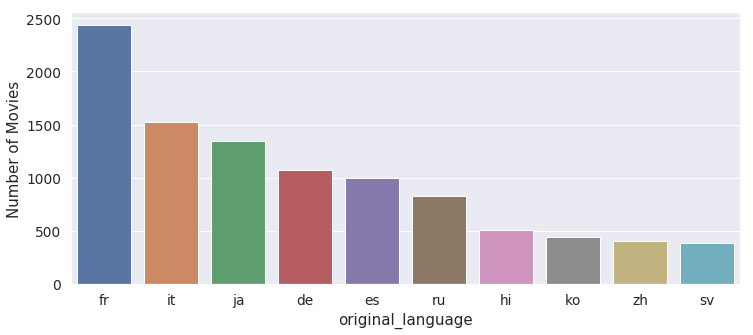

In [16]:
df_movies_languages_pan = df_movies_languages.limit(11).toPandas()
print("Number of Movies vs Language - Excluding English")
plt.figure(figsize=(12,5))
sns.barplot(x='original_language', y='Number of Movies', data=df_movies_languages_pan.iloc[1:11])
plt.show()

del df_movies_languages


## Franchise Movies

In [17]:
df_movies_franchise = df_movies_metadata.filter(df_movies_metadata["belongs_to_collection"].isNull()==False)

In [18]:
split_col = F.split(df_movies_franchise['belongs_to_collection'], ',')
df_movies_franchise = df_movies_franchise.withColumn('name', split_col.getItem(1))
#df_movies_franchise.columns

In [19]:

print("Highest Grossing Movie Franchises\n")
df_movies_franchise = df_movies_franchise.withColumn('name', df_movies_franchise['name'].substr(10, 100))
df_movies_franchise = df_movies_franchise.withColumn('lengthofmovie', length(df_movies_franchise.name))
df_movies_franchise = df_movies_franchise.filter(df_movies_franchise.lengthofmovie>0)
df_movies_franchise = df_movies_franchise.withColumn('Moviename', regexp_replace('name', "'", ''))
df_movies_franchise = df_movies_franchise.groupBy('Moviename').agg(F.sum('revenue').alias("Total_Revenue"),F.count('Moviename').alias("Number of Movies"),F.avg('revenue').alias("Average_revenue"))
df_movies_franchise = df_movies_franchise.filter(isnan(df_movies_franchise.Total_Revenue)==False)
df_movies_franchise.orderBy("Total_Revenue",ascending=False).show()



Highest Grossing Movie Franchises

+--------------------+-------------+----------------+-------------------+
|           Moviename|Total_Revenue|Number of Movies|    Average_revenue|
+--------------------+-------------+----------------+-------------------+
|Harry Potter Coll...|7.707367425E9|               8|    9.63420928125E8|
|Star Wars Collection| 7.43449479E9|               8|     9.2931184875E8|
|James Bond Collec...|7.106970239E9|              26|2.733450091923077E8|
|The Fast and the ...|5.125098793E9|               8|    6.40637349125E8|
|Pirates of the Ca...|4.521576826E9|               5|      9.043153652E8|
|The Twilight Coll...| 3.34210729E9|               5|       6.68421458E8|
|  Ice Age Collection|3.216708553E9|               5|      6.433417106E8|
|Jurassic Park Col...|3.031484143E9|               4|     7.5787103575E8|
|The Hobbit Collec...|2.935523356E9|               3|9.785077853333334E8|
|The Avengers Coll...|2.924961604E9|               2|      1.462480802E9|
|Th

In [20]:
print("Most Successful Movie Franchises - By Average Gross\n")

df_movies_franchise.orderBy("Average_Revenue",ascending=False).show()

Most Successful Movie Franchises - By Average Gross

+--------------------+-------------+----------------+-------------------+
|           Moviename|Total_Revenue|Number of Movies|    Average_revenue|
+--------------------+-------------+----------------+-------------------+
|The Avengers Coll...|2.924961604E9|               2|      1.462480802E9|
|Finding Nemo Coll...|1.968906425E9|               2|      9.844532125E8|
|The Hobbit Collec...|2.935523356E9|               3|9.785077853333334E8|
|The Lord of the R...|2.916544743E9|               3|       9.72181581E8|
|Harry Potter Coll...|7.707367425E9|               8|    9.63420928125E8|
|Star Wars Collection| 7.43449479E9|               8|     9.2931184875E8|
|Pirates of the Ca...|4.521576826E9|               5|      9.043153652E8|
|The Secret Life o...| 8.75457937E8|               1|       8.75457937E8|
|Spider-Man Collec...|2.496346518E9|               3|       8.32115506E8|
|The Dark Knight C...|2.463716216E9|               3|8.2123

In [21]:
print("Longest Running Movie Franchises\n")

df_movies_franchise.orderBy("Number of Movies",ascending=False).show()
del df_movies_franchise

Longest Running Movie Franchises

+--------------------+-------------+----------------+--------------------+
|           Moviename|Total_Revenue|Number of Movies|     Average_revenue|
+--------------------+-------------+----------------+--------------------+
|James Bond Collec...|7.106970239E9|              26| 2.733450091923077E8|
|Halloween Collection| 2.47168056E8|               8|         3.0896007E7|
|Star Wars Collection| 7.43449479E9|               8|      9.2931184875E8|
|The Fast and the ...|5.125098793E9|               8|     6.40637349125E8|
|Harry Potter Coll...|7.707367425E9|               8|     9.63420928125E8|
|Police Academy Co...| 3.04643237E8|               7|4.3520462428571425E7|
|      Saw Collection| 8.78307806E8|               7|1.2547254371428572E8|
|    Rocky Collection|1.337126094E9|               7|1.9101801342857143E8|
|Star Trek: The Or...|      6.229E8|               6|1.0381666666666667E8|
|Paranormal Activi...| 8.83848567E8|               6|       1.4730

## Production Companies

In [22]:
df_movies_company = df_movies_metadata.filter(df_movies_metadata["production_companies"].isNull()==False)
df_movies_company = df_movies_company.withColumn("production_companies",ltrim(df_movies_company.production_companies))
df_movies_company = df_movies_company.withColumn("production_companies",rtrim(df_movies_company.production_companies))
split_col = F.split(df_movies_company['production_companies'], ',')
df_movies_company = df_movies_company.withColumn('comp_name1', split_col.getItem(0))
df_movies_company = df_movies_company.withColumn('comp_name2',split_col.getItem(2))
df_movies_company = df_movies_company.withColumn('comp_name3',split_col.getItem(4))
df_movies_company = df_movies_company.withColumn('comp_name4',split_col.getItem(6))
df_movies_company = df_movies_company.withColumn('comp_name5',split_col.getItem(8))
df_movies_company = df_movies_company.withColumn('comp_name6',split_col.getItem(10))
df_movies_company = df_movies_company.withColumn('comp_name1', df_movies_company['comp_name1'].substr(11, 100))
df_movies_company = df_movies_company.withColumn('comp_name2', df_movies_company['comp_name2'].substr(11, 100))
df_movies_company = df_movies_company.withColumn('comp_name3', df_movies_company['comp_name3'].substr(11, 100))
df_movies_company = df_movies_company.withColumn('comp_name4', df_movies_company['comp_name4'].substr(11, 100))
df_movies_company = df_movies_company.withColumn('comp_name5', df_movies_company['comp_name5'].substr(11, 100))
df_movies_company = df_movies_company.withColumn('comp_name6', df_movies_company['comp_name6'].substr(11, 100))
df_movies_company.select(["comp_name1","comp_name2","comp_name3","comp_name4","comp_name5","comp_name6","revenue"]).show()


+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+------------+
|          comp_name1|          comp_name2|          comp_name3|          comp_name4|          comp_name5| comp_name6|     revenue|
+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+------------+
|'Pixar Animation ...|                null|                null|                null|                null|       null|3.73554033E8|
|  'TriStar Pictures'|      'Teitler Film'|'Interscope Commu...|                null|                null|       null|2.62797249E8|
|      'Warner Bros.'|    'Lancaster Gate'|                null|                null|                null|       null|         NaN|
| to find a better...|                null|                null|                null|                null|       null|         NaN|
|'Sandollar Produc...|'Touchstone Pictu...|                null|            

In [23]:


# df_movies_company = df_movies_company.withColumn('lengthofmovie_company', length(df_movies_company.comp_name))
# df_movies_company = df_movies_company.filter(df_movies_company.comp_name.isNull()==False)
df_movies_company = df_movies_company.withColumn('comp_name1', regexp_replace('comp_name1', "'", ''))
df_movies_company = df_movies_company.withColumn('comp_name2', regexp_replace('comp_name2', "'", ''))
df_movies_company = df_movies_company.withColumn('comp_name3', regexp_replace('comp_name3', "'", ''))
df_movies_company = df_movies_company.withColumn('comp_name4', regexp_replace('comp_name4', "'", ''))
df_movies_company = df_movies_company.withColumn('comp_name5', regexp_replace('comp_name5', "'", ''))
df_movies_company = df_movies_company.withColumn('comp_name6', regexp_replace('comp_name6', "'", ''))
# df_movies_company = df_movies_company.groupBy('Production_Company').agg(F.sum('revenue').alias("Total_Revenue"),F.count('Production_Company').alias("Number of Movies"),F.avg('revenue').alias("Average_revenue"))
# df_movies_company = df_movies_company.filter(isnan(df_movies_company.Total_Revenue)==False)

df_comp1 = df_movies_company.select(["comp_name1","revenue"])
df_comp2 = df_movies_company.select(["comp_name2","revenue"])
df_comp3 = df_movies_company.select(["comp_name3","revenue"])
df_comp4 = df_movies_company.select(["comp_name4","revenue"])
df_comp5 = df_movies_company.select(["comp_name5","revenue"])
df_comp6 = df_movies_company.select(["comp_name6","revenue"])



In [24]:
df_comp1 = df_comp1.filter(df_comp1.comp_name1.isNull()==False )
df_comp1 = df_comp1.filter(isnan(df_comp1.revenue)==False)
                           
df_comp2 = df_comp2.filter(df_comp2.comp_name2.isNull()==False )
df_comp2 = df_comp2.filter(isnan(df_comp2.revenue)==False)

df_comp3 = df_comp3.filter(df_comp3.comp_name3.isNull()==False )
df_comp3 = df_comp3.filter(isnan(df_comp3.revenue)==False)

df_comp4 = df_comp4.filter(df_comp4.comp_name4.isNull()==False )
df_comp4 = df_comp4.filter(isnan(df_comp4.revenue)==False)

df_comp5 = df_comp5.filter(df_comp5.comp_name5.isNull()==False )
df_comp5 = df_comp5.filter(isnan(df_comp5.revenue)==False)

df_comp6 = df_comp6.filter(df_comp6.comp_name6.isNull()==False )
df_comp6 = df_comp6.filter(isnan(df_comp6.revenue)==False)

In [25]:
#df_movies_company.filter(df_movies_company.Production_Company.contains("Warner")).show()
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

final_companies = unionAll(df_comp1,df_comp2,df_comp3,df_comp4,df_comp5,df_comp6)



In [26]:

final_companies = final_companies.drop_duplicates()
final_companies.show()

+--------------------+------------+
|          comp_name1|     revenue|
+--------------------+------------+
|     Silver Pictures| 1.1534477E7|
|  Paramount Pictures|     1.163E8|
|    TriStar Pictures| 2.6828365E7|
|      Epithète Films|   2503829.0|
|Walt Disney Pictures|   4562146.0|
|  Paramount Pictures|       2.9E7|
|  The Geffen Company| 3.8748395E7|
|Imagine Entertain...|3.45141403E8|
|Metro-Goldwyn-May...| 1.8899204E7|
|  Franchise Pictures| 1.8720175E7|
|Columbia Pictures...|   2070806.0|
|         Davis-Films| 7.0752904E7|
|Touchwood Pacific...| 2.2518097E7|
|  Universal Pictures|  2.024679E7|
| Ang Lee Productions|   6933459.0|
|  Universal Pictures| 1.1341016E7|
|        and patients|         5.0|
|   BIM Distribuzione|1.19114517E8|
|  Universal Pictures|2.04999686E8|
|         StudioCanal| 1.2206028E7|
+--------------------+------------+
only showing top 20 rows



In [27]:
final_companies = final_companies.withColumn("comp_name1",ltrim(final_companies.comp_name1))
final_companies = final_companies.withColumn("Production Company",rtrim(final_companies.comp_name1))
final_companies = final_companies.groupBy('Production Company').agg(F.sum('revenue').alias("Total_Revenue"),F.count('Production Company').alias("Number of Movies"),F.avg('revenue').alias("Average_revenue"))
final_companies = final_companies.filter(isnan(final_companies.Total_Revenue)==False)
final_companies = final_companies.filter(isnan(final_companies.Average_revenue)==False)

print("Highest Earning Production Companies\n")
final_companies.orderBy("Total_Revenue",ascending=False).show()


Highest Earning Production Companies

+--------------------+---------------+----------------+--------------------+
|  Production Company|  Total_Revenue|Number of Movies|     Average_revenue|
+--------------------+---------------+----------------+--------------------+
|        Warner Bros.|5.7979468366E10|             444| 1.305843882117117E8|
|  Universal Pictures|5.1801695351E10|             419|1.2363173114797136E8|
|  Paramount Pictures| 4.418503552E10|             345|1.2807256672463769E8|
|Walt Disney Pictures|3.9031290318E10|             136|      2.8699478175E8|
|Twentieth Century...|3.6617732231E10|             290|1.2626804217586207E8|
|   Columbia Pictures|2.9491523222E10|             218| 1.352822166146789E8|
|     New Line Cinema| 1.988246467E10|             178|1.1169923971910113E8|
|Amblin Entertainment|1.5548980789E10|              61|2.5490132440983605E8|
|      DreamWorks SKG|1.4731305927E10|              71|2.0748318207042253E8|
|    Relativity Media|1.3223640704E10|

In [28]:
print("Most Successful Production Companies\n")
final_companies.filter(final_companies['Number of Movies']>=15).orderBy("Average_Revenue",ascending=False).show()

del df_movies_company
del final_companies



Most Successful Production Companies

+--------------------+---------------+----------------+--------------------+
|  Production Company|  Total_Revenue|Number of Movies|     Average_revenue|
+--------------------+---------------+----------------+--------------------+
|Pixar Animation S...|1.0825274875E10|              17|        6.36780875E8|
|      Marvel Studios|1.1699635216E10|              19| 6.157702745263158E8|
|           Lucasfilm|  9.885691189E9|              21|4.7074719947619045E8|
|DreamWorks Animation|1.2478167492E10|              31|        4.02521532E8|
|Jerry Bruckheimer...|  8.382310068E9|              21|3.9915762228571427E8|
|              Dentsu|   6.85320539E9|              18| 3.807336327777778E8|
|       1492 Pictures|  5.252601781E9|              15|3.5017345206666666E8|
|  Legendary Pictures|1.1882939773E10|              37| 3.211605344054054E8|
| Atlas Entertainment|   4.55105535E9|              15|         3.0340369E8|
|Walt Disney Pictures|3.9031290318E10|

## Title and Overview Wordclouds

In [29]:
!python -m pip install --user wordcloud

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [30]:
from wordcloud import WordCloud, STOPWORDS

In [31]:
!python -m pip install --user plotly

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
#plotly.tools.set_credentials_file(username='rounakbanik', api_key='xTLaHBy9MVv5szF4Pwan')

In [33]:
df_title = df_movies_metadata.select("title")

df_title = df_title.filter(df_title.title.contains('/') ==False)
df_title = df_title.filter(df_title.title.contains('[') ==False)
df_title = df_title.filter(df_title.title.contains('The') ==False)
df_title = df_title.filter(df_title.title.contains('It') ==False)
df_title = df_title.filter(df_title.title.contains('Released') ==False)
import pyspark.sql.functions as sf


In [34]:
df_title = df_title.withColumn('constant', F.lit('NE'))
from pyspark.sql.functions import collect_list
grouped_df = df_title.groupby('constant').agg(collect_list('title').alias("merged_titles"))

from pyspark.sql.functions import concat_ws

grouped_df = grouped_df.withColumn("merged_titles", concat_ws(" ", "merged_titles"))
grouped_df.show()

+--------+--------------------+
|constant|       merged_titles|
+--------+--------------------+
|      NE|Toy Story Jumanji...|
+--------+--------------------+



In [35]:
title_corpus = grouped_df.select("merged_titles").rdd.collect()
title_corpus = str(title_corpus[0][:])
#print(title_corpus)

In [36]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
# example_sent = "This is a sample sentence, showing off the stop words filtration."
  
stop_words = set(stopwords.words('english')) 
  
word_tokens = word_tokenize(title_corpus) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 

In [37]:
title_corpus = ' '.join(filtered_sentence)

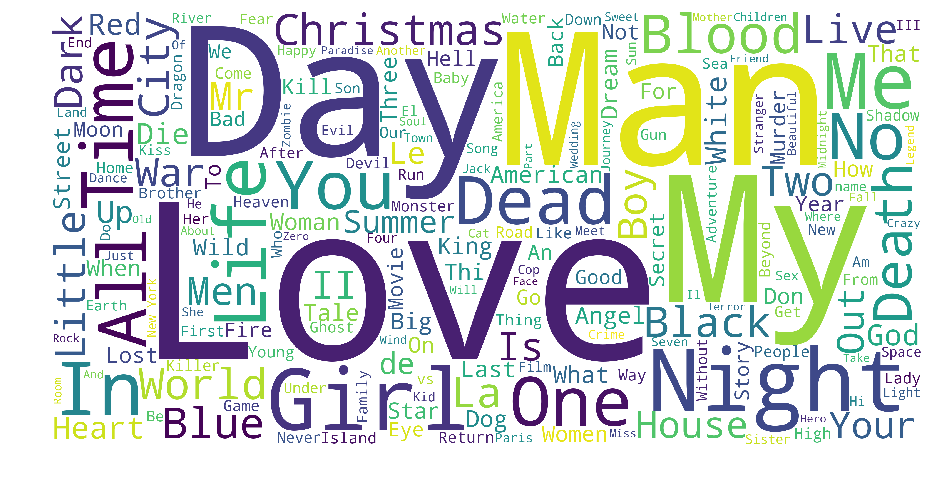

In [38]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

del df_title
del title_corpus


In [39]:
df_overview = df_movies_metadata.select("overview")

df_overview = df_overview.filter(df_overview.overview.contains('/') ==False)
df_overview = df_overview.filter(df_overview.overview.contains('[') ==False)
df_overview = df_overview.filter(df_overview.overview.contains('The') ==False)
df_overview = df_overview.filter(df_overview.overview.contains('It') ==False)
df_overview = df_overview.filter(df_overview.overview.contains('When') ==False)
df_overview = df_overview.filter(df_overview.overview.contains('In') ==False)
df_overview = df_overview.filter(df_overview.overview.contains('But') ==False)
df_overview = df_overview.filter(df_overview.overview.contains('Released') ==False)

import pyspark.sql.functions as sf


In [40]:
df_overview = df_overview.withColumn('constant', sf.lit('NE'))
from pyspark.sql.functions import collect_list
grouped_df = df_overview.groupby('constant').agg(collect_list('overview').alias("merged_overview"))

from pyspark.sql.functions import concat_ws

grouped_df = grouped_df.withColumn("merged_overview", concat_ws(" ", "merged_overview"))
grouped_df.show()

+--------+--------------------+
|constant|     merged_overview|
+--------+--------------------+
|      NE|"Cheated on, mist...|
+--------+--------------------+



In [41]:
overview_corpus = grouped_df.select("merged_overview").rdd.collect()
overview_corpus = str(overview_corpus[0][:])
#print(title_corpus)

In [42]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
# example_sent = "This is a sample sentence, showing off the stop words filtration."
  
stop_words = set(stopwords.words('english')) 
  
word_tokens = word_tokenize(overview_corpus) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 

In [43]:
overview_corpus = ' '.join(filtered_sentence)

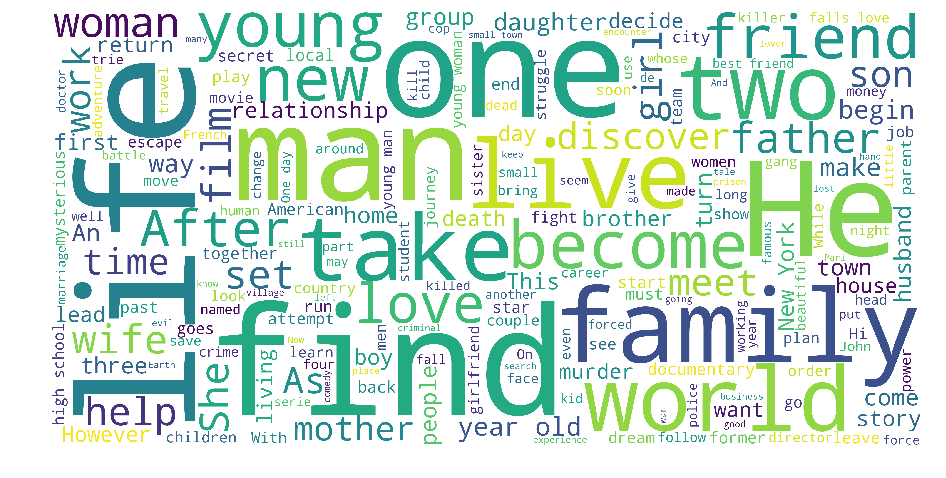

In [44]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

del overview_corpus
del df_overview

## Production Countries

In [45]:
df_movies_countries = df_movies_metadata.filter(df_movies_metadata["production_countries"].isNull()==False)

In [46]:
split_col = F.split(df_movies_countries['production_countries'], ',')
df_movies_countries = df_movies_countries.withColumn('country_name', split_col.getItem(1))


In [47]:
# df_movies_countries.select("country_name").show()
df_movies_countries = df_movies_countries.withColumn('country_name', df_movies_countries['country_name'].substr(11, 100))
df_movies_countries = df_movies_countries.withColumn('lengthofcountry', length(df_movies_countries.country_name))
df_movies_countries = df_movies_countries.filter(df_movies_countries.lengthofcountry>1)
df_movies_countries = df_movies_countries.filter(df_movies_countries["country_name"].isNull()==False)


from pyspark.sql.functions import substring, length, col, expr
df_movies_countries = df_movies_countries.withColumn("country_name",expr("substring(country_name, 1, length(country_name)-2)"))
df_movies_countries = df_movies_countries.withColumn('country_name', regexp_replace('country_name', "'", ''))
df_movies_countries = df_movies_countries.withColumn("country_name",ltrim(df_movies_countries.country_name))
df_movies_countries.select("country_name").show()

+--------------------+
|        country_name|
+--------------------+
|United States of ...|
|United States of ...|
|United States of ...|
|United States of ...|
|United States of ...|
|             Germany|
|United States of ...|
|United States of ...|
|      United Kingdom|
|United States of ...|
|              France|
|United States of ...|
|United States of ...|
|              France|
|              France|
|      United Kingdom|
|United States of ...|
|United States of ...|
|United States of ...|
|United States of ...|
+--------------------+
only showing top 20 rows



In [48]:

# print("Highest Grossing Movie Franchises\n")

# df_movies_franchise = df_movies_franchise.withColumn('lengthofmovie', length(df_movies_franchise.name))
# df_movies_franchise = df_movies_franchise.filter(df_movies_franchise.lengthofmovie>0)
df_movies_countries = df_movies_countries.groupBy('country_name').agg(F.count('country_name').alias("Number of Movies produced in Country"))

# df_movies_countries.orderBy("Number of Movies produced in Country",ascending=False).show()

df_movies_countries = df_movies_countries.select(["country_name","Number of Movies produced in Country"])


In [49]:
df_movies_countries = df_movies_countries.filter(df_movies_countries.country_name.contains("United States")==False)
df_movies_countries.orderBy("Number of Movies produced in Country",ascending=False).show()

+--------------+------------------------------------+
|  country_name|Number of Movies produced in Country|
+--------------+------------------------------------+
|United Kingdom|                                2856|
|        France|                                2455|
|        Canada|                                1385|
|         Italy|                                1354|
|         Japan|                                1347|
|       Germany|                                1294|
|         India|                                 748|
|        Russia|                                 716|
|         Spain|                                 548|
|     Australia|                                 476|
|   South Korea|                                 426|
|     Hong Kong|                                 410|
|        Sweden|                                 373|
|       Finland|                                 303|
|       Denmark|                                 275|
|         China|            

In [50]:
con_df = df_movies_countries.toPandas()
data = [ dict(
        type = 'choropleth',
        locations = con_df['country_name'],
        locationmode = 'country names',
        z = con_df['Number of Movies produced in Country'],
        text = con_df['country_name'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(255, 0, 0)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the MovieLens Movies (Apart from US)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )
del df_movies_countries

## Content Based Plot Evaluator

In [51]:

df_met_dat = df_movies_metadata.fillna(' ',subset=['tagline'])
df_met_dat = df_met_dat.drop_duplicates(["title"])

In [52]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import re

# data = [("[{'id': 931, 'name' : 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}",)]
# df = sc.parallelize(data).toDF('str:string')
# Define the function you want to return
def extract(s):
#     print(s)
#     all_matches=s[1]
    all_matches = re.findall(r"'name' *: *'[a-zA-Z ]*'", s)
    return all_matches

# Create the UDF, note that you need to declare the return schema matching the returned type
extract_udf = udf(extract, ArrayType(StringType()))

from pyspark.sql.functions import udf, col

join_udf = udf(lambda x: ",".join(x))

In [53]:
df_met_dat2 = df_met_dat.withColumn('genres', extract_udf('genres'))

from pyspark.sql.functions import udf, col

join_udf = udf(lambda x: ",".join(x))
df_met_dat2 = df_met_dat2.withColumn("genres", join_udf(col("genres")))

df_met_dat2 = df_met_dat2.withColumn('genres', regexp_replace('genres', "'name':", ''))
df_met_dat2 = df_met_dat2.withColumn('genres', regexp_replace('genres', "'name' :", ''))
df_met_dat2 = df_met_dat2.withColumn('genres', regexp_replace('genres','"', ''))

In [54]:
df_met_dat2 = df_met_dat2.withColumn('description', 
                    F.concat(F.col('overview'),F.lit(' '), F.col('tagline'),F.col('genres')))

In [55]:
# Ideal Number of Characters of your Description with Genre - [300-400]

# Sample Description

# Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole 
# to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage. 
# Mankind was born on Earth. It was never meant to die here. 'Adventure', 'Drama', 'Science Fiction'")

# The Lion King
mymovie_plot1 = "After the murder of his father, a young lion prince flees his kingdom only to learn the true meaning of responsibility and bravery. In Africa, the lion cub Simba is the pride and joy of his parents King Mufasa and Queen Sarabi. Mufasa prepares Simba to be the next king of the jungle"
# Ad Astra
mymovie_plot2 = "Thirty years ago, Clifford McBride led a voyage into deep space, but the ship and crew were never heard from again. Now his son a fearless astronaut -- must embark on a daring mission to Neptune to uncover the truth about his missing father and a mysterious power surge that threatens the stability of the universe."
# Terminator -3
mymovie_plot3 = "In Mexico City, a newly modified liquid Terminator the Rev-9 model arrives from the future to kill a young factory worker named Dani Ramos. Also sent back in time is Grace, a hybrid cyborg human who must protect  from the seemingly indestructible robotic assassin. But the two women soon find some much-needed help from a pair of unexpected allies seasoned warrior and the T-800 Terminator"
# Frozen 2
mymovie_plot4 = "Elsa the Snow Queen has an extraordinary gift -- the power to create ice and snow. But no matter how happy she is to be surrounded by the people of Arendelle, Elsa finds herself strangely unsettled. After hearing a mysterious voice call out to her, Elsa travels to the enchanted forests and dark seas beyond her kingdom -- an adventure that soon turns into a journey of self-discovery."


my_genre1 = "'Animation', 'Musical', 'Drama', 'Family', 'Adventure', 'Musical Drama' "

my_genre2 = "'Drama','Thriller','Mystery','Science Fiction','Epic'"

my_genre3 = "'Science Fiction','Adventure','Fantasy','Action'"

my_genre4 = "'Family','Fantasy','Drama','Animation','Comedy','Musical','Adventure'"


# Ad Astra
desc1 = "Thirty years ago, Clifford McBride led a voyage into deep space, but the ship and crew were never heard from again. Now his son a fearless astronaut -- must embark on a daring mission to Neptune to uncover the truth about his missing father and a mysterious power surge that threatens the stability of the universe."
genre1 = "'Drama','Thriller','Mystery','Science Fiction','Epic'" 
# MI Fallout
desc2 = "After a mission to recover a deadly weapon goes wrong, IMF agent Ethan Hunt and his team are forced to work alongside CIA agent Augustus Walker as they must race against time to continue their assignment. When Lane escapes from prison, Hunt must do whatever it takes to capture him once more"
genre2 = "'Action','Thriller','Spy','Adventure'"

# Aladdin
desc3 = "A kind-hearted street urchin Aladdin vies for the love of the beautiful princess Jasmine, the princess of Agrabah. When he finds a magic lamp, he uses the genie's magic power to make himself a prince in order to marry her. He's also on a mission to stop the powerful Jafar who plots to steal the magic lamp that could make his deepest wishes come true"
genre3 = "'Comedy','Family','Adventure','Romance','Fantasy','Musical'"

# Ant Man and the Wasp
desc4 = "Scott Lang is grappling with the consequences of his choices as both a superhero and a father. Approached by Hope van Dyne and Dr. Hank Pym, Lang must once again don the Ant-Man suit and fight alongside the Wasp. The urgent mission soon leads to secret revelations from the past as the dynamic duo finds itself in an epic battle against a powerful new enemy"
genre4 = "'Superhero','Action','Comedy','Adventure','Science Fiction','Fantasy'"

# Joker
desc5 = "Forever alone in a crowd, failed comedian Arthur Fleck seeks connection as he walks the streets of Gotham City. Arthur wears two masks -- the one he paints for his day job as a clown, and the guise he projects in a futile attempt to feel like he's part of the world around him. Isolated, bullied and disregarded by society, Fleck begins a slow descent into madness as he transforms into the criminal mastermind known as the Joker"
genre5 = "'Crime','Psychological thriller','Drama'"

# Little Women
desc6 = "In the years after the Civil War, Jo March lives in New York and makes her living as a writer, while her sister Amy studies painting in Paris. Amy has a chance encounter with Theodore, a childhood crush who proposed to Jo but was ultimately rejected. Their oldest sibling, Meg, is married to a schoolteacher, while shy sister Beth develops a devastating illness that brings the family back together."
genre6 = "'Novel','Comedy'"
# Cats
desc7 = "A tribe of cats must decide yearly which one will ascend to the Heaviside Layer and come back to a new life."
genre7 = "'Musical','Comedy','Fantasy','Drama','Family'"

# The Goldflinch
desc8 = "Theodore Decker was 13 years old when his mother was killed in a bombing at the Metropolitan Museum of Art in New York. The tragedy changes the course of his life, sending him on a stirring odyssey of grief and guilt, reinvention and redemption, and even love. Through it all, he holds on to one tangible piece of hope from that terrible day -- a painting of a tiny bird chained to its perch."
genre8 = "'Novel'"

# Gemini Man
desc9 = "Henry Brogan is an elite 51-year-old assassin who's ready to call it quits after completing his 72nd job. His plans get turned upside down when he becomes the target of a mysterious operative who can seemingly predict his every move. To his horror, Brogan soon learns that the man who's trying to kill him is a younger, faster, cloned version of himself."
genre9 = "'Action','Thriller','Adventure'"
# Escape Room
desc10= "Six adventurous strangers travel to a mysterious building to experience the escape room -- a game where players compete to solve a series of puzzles to win $10,000. What starts out as seemingly innocent fun soon turns into a living nightmare as the four men and two women discover each room is an elaborate trap that's part of a sadistic game of life or death"
genre10 = "'Horror','Thriller','Mystery'"

# The Hunt
desc11 = "Twelve strangers wake up in a clearing. They don't know where they are -- or how they got there. In the shadow of a dark internet conspiracy theory, ruthless elitists gather at a remote location to hunt humans for sport. But their master plan is about to be derailed when one of the hunted, Crystal, turns the tables on her pursuers"
genre11 = "'Thriller','Horror','Mystery','Adventure','Action'"

# Star wars
desc12 = "When it's discovered that the evil Emperor Palpatine did not die at the hands of Darth Vader, the rebels must race against the clock to find out his whereabouts. Finn and Poe lead the Resistance to put a stop to the First Order's plans to form a new Empire, while Rey anticipates her inevitable confrontation with Kylo Ren. Warning: Some flashing-lights scenes in this film may affect photosensitive viewers"
genre12 = "'Science Fiction','Action','Epic','Fantasy'"

# Avengers-Infinity War
desc13 = "Iron Man, Thor, the Hulk and the rest of the Avengers unite to battle their most powerful enemy yet -- the evil Thanos. On a mission to collect all six Infinity Stones, Thanos plans to use the artifacts to inflict his twisted will on reality. The fate of the planet and existence itself has never been more uncertain as everything the Avengers have fought for has led up to this moment."
genre13 = "'Superhero', 'Fantasy','Science Fiction','Adventure'"

# Jurassic World
desc14 = "Three years after the destruction of the Jurassic World theme park, Owen Grady and Claire Dearing return to the island of Isla Nublar to save the remaining dinosaurs from a volcano that's about to erupt. They soon encounter terrifying new breeds of gigantic dinosaurs, while uncovering a conspiracy that threatens the entire planet"
genre14 = "'Action','Adventure','Science Fiction'"

# Marriage Story
desc15 = "A stage director and his actor wife struggle through a gruelling, coast-to-coast divorce that pushes them to their personal and creative extremes."
genre15 = "'Romance','Drama'"

# Hobbs and Shaw
desc16 = "Brixton Lorr is a cybernetically enhanced soldier who possesses superhuman strength, a brilliant mind and a lethal pathogen that could wipe out half of the world's population. It's now up to hulking lawman Luke Hobbs and lawless operative Deckard Shaw to put aside their past differences and work together to prevent the seemingly indestructible Lorr from destroying humanity"
genre16 = "'Action','Comedy','Adventure'"

# Godzilla
desc17 = "Members of the crypto-zoological agency Monarch face off against a battery of god-sized monsters, including the mighty Godzilla, who collides with Mothra, Rodan, and his ultimate nemesis, the three-headed King Ghidorah. When these ancient super-species-thought to be mere myths-rise again, they all vie for supremacy, leaving humanity's very existence hanging in the balance"
genre17 = "'Monster','Action','Fantasy','Science Fiction'"
# out = Recommend(desc17,genre17,df_met_dat2)
# out = out.sort_values(by=['revenue'])
movie_description = desc2
movie_genre = genre2

In [56]:
# def Recommend(movie_description,movie_genre,df_met_dat2):
    

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 


word_tokens = word_tokenize(movie_description) 
word_tokens = [" "+w+" " for w in word_tokens]  
filtered_sentence = [w.strip() for w in word_tokens if not w in stop_words] 

myplot_summary_filt = ' '.join(filtered_sentence)

my_soup = myplot_summary_filt + movie_genre

df_met_dat2 = df_met_dat2.fillna(' ',subset=['description'])
df_met_dat2 = df_met_dat2.filter(df_met_dat2.title.isNull()==False)
df_met_dat2 = df_met_dat2.filter(df_met_dat2.title.contains('[') ==False)

df_met_dat2 = df_met_dat2.filter(df_met_dat2.id>=1)
df_met_dat2 =  df_met_dat2.withColumn('description', regexp_replace('description',"'", ''))
df_met_dat2 = df_met_dat2.filter(df_met_dat2.title.contains("my_title")==False)
df_met_dat2 = df_met_dat2.filter(length(df_met_dat2.revenue)>0)

df_met_dat2 = df_met_dat2.filter(isnan(df_met_dat2.revenue)==False)

row = ('1','1','1','1','1','1','1','1','1','1','1','1','1','1','1','1','1','my_title','1','1','1','1','1',my_soup)

newRow = spark.createDataFrame([row], df_met_dat2.columns)

df_met_dat2 = df_met_dat2.union(newRow)


from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
stop_words = [" "+str(i)+" " for i in stop_words]
# print(stop_words)
for wrd in stop_words:


    df_met_dat2 =  df_met_dat2.withColumn('description', regexp_replace('description', wrd, ' '))

# df_met_dat = df_met_dat2

from pyspark.ml.feature import HashingTF, IDF, Tokenizer

tokenizer = Tokenizer(inputCol="description", outputCol="des_words")

print("Size of Datafram after Filtering:",df_met_dat2.count())
wordsData = tokenizer.transform(df_met_dat2)

hashingTF = HashingTF(inputCol="des_words", outputCol="rawFeatures", numFeatures=80000)
featurizedData = hashingTF.transform(wordsData)
# alternatively, CountVectorizer can also be used to get term frequency vectors

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
#rescaledData.columns
#     rescaledData.select(["description","features"]).show()

from pyspark.ml.feature import Normalizer
normalizer = Normalizer(inputCol="features", outputCol="norm")
data = normalizer.transform(rescaledData)

feat = data.select("norm").toPandas()
feat_num = feat['norm'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)
features = np.apply_along_axis(lambda x : x[0], 1, feat_num)


from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
cosine_sim = linear_kernel(features, features)

columns_to_drop = ['belongs_to_collection', 'tagline','overview']
df_met_dat2 = df_met_dat2.drop(*columns_to_drop)


smd = data.toPandas()
smd = smd.reset_index()

indices = pd.Series(smd.index, index=smd['title'])


titles = smd[['id','title','budget','return','revenue','production_companies']]



Size of Datafram after Filtering: 6430


In [57]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:31]

    movie_indices = [i[0] for i in sim_scores]



    return titles.iloc[movie_indices]    





In [64]:
# out = get_recommendations("The Dark Knight").head(10).sort_values(by=['revenue'])

out = get_recommendations("my_title").head(10).sort_values(by=['revenue'])
get_recommendations("my_title").head(10).sort_values(by=['revenue'])

,id,title,budget,return,revenue,production_companies
2507,203801,The Man from U.N.C.L.E.,7.5E7,1.4419347866666667,1.08145109E8,"[{'name': 'Davis Entertainment', 'id': 1302}, ..."
3947,754,Face/Off,8.0E7,3.070951825,2.45676146E8,"[{'name': 'Paramount Pictures', 'id': 4}, {'na..."
5036,81796,Lockout,2.0E7,1.6102015,3.220403E7,"[{'name': 'Canal+', 'id': 5358}, {'name': 'Eur..."
5515,956,Mission: Impossible III,1.5E8,2.6523334133333334,3.97850012E8,"[{'name': 'Paramount Pictures', 'id': 4}, {'na..."
5541,954,Mission: Impossible,8.0E7,5.7212044875,4.57696359E8,"[{'name': 'Paramount Pictures', 'id': 4}, {'na..."
5855,17277,The Fall of the Roman Empire,1.9E7,0.25,4750000.0,"[{'name': 'Samuel Bronston Productions', 'id':..."
1577,955,Mission: Impossible II,1.25E8,4.37110484,5.46388105E8,"[{'name': 'Paramount Pictures', 'id': 4}, {'na..."
5373,56292,Mission: Impossible - Ghost Protocol,1.45E8,4.79112675862069,6.9471338E8,"[{'name': 'Paramount Pictures', 'id': 4}, {'na..."
3625,54287,Hangar 18,NaN,NaN,6000000.0,"[{'name': 'Sunn Classic Pictures', 'id': 6177}]"
2688,341013,Atomic Blonde,3.0E7,3.0002648333333335,9.0007945E7,"[{'name': 'Denver and Delilah Productions', 'i..."


In [65]:

# out = Recommend(desc2,genre2,df_met_dat2)
# out = out.sort_values(by=['revenue'])
l = out["revenue"].tolist()
r = out["budget"].tolist()

tot_prof = 0
tot_rev =0 
tot_bud = 0
count=0
for i in range(len(l)):
    re = float(l[i])
    bu = float(r[i])
    if re>0 and bu>0:
        tot_rev+=re
        tot_bud+=bu
        prof = re/bu
        tot_prof+=prof
        count+=1
ratings = spark.read.format("csv").option("header","true").load("ratings.csv")


ratings = ratings.select(["movieId","rating"])
ratings = ratings.groupBy("movieId").agg(F.mean('rating'))
# ratings.show()

ratings_mod = ratings.withColumn("id",ratings.movieId)
ratings_mod = ratings_mod.select(["id","avg(rating)"])

ratings_pand = ratings_mod.toPandas()

# final_df = out.join(ratings_pand, on="id",how='inner')
final_df = pd.merge(out, ratings_pand[['id', 'avg(rating)']],on='id')



print("Expected Rating for the new Movie (out of 5): ",final_df["avg(rating)"].mean(),"\n")        
print("Expected Profit ratio for the new movie is:",tot_rev/(tot_bud),"\n") 
def convert(lst): 
    return eval(lst) 
prod = out["production_companies"].tolist()
companies =[]
for l in prod:
    li = eval(l)
    for j in li:
#         print(j['name'])
        companies.append(j['name'])

# print(companies)
comp_dict = {i:companies.count(i) for i in set(companies)}

print("Companies that could accept your Script")
comp = sorted(comp_dict.items(), key=lambda x: x[1], reverse=True)

print("Company Name", "Number of movies produced with similar plotline")
for c in comp:
    print(c[0],c[1])


Expected Rating for the new Movie (out of 5):  3.610706518673781 

Expected Profit ratio for the new movie is: 3.559987687845304 

Companies that could accept your Script
Company Name Number of movies produced with similar plotline
Paramount Pictures 5
Cruise/Wagner Productions 3
Denver and Delilah Productions 1
Permut Presentations 1
Sunn Classic Pictures 1
Film i Väst 1
Ciné+ 1
Wigram Productions 1
Closed on Mondays Entertainment 1
EuropaCorp 1
Revolution Sun Studios 1
Studio Babelsberg 1
China Film Group Corporation (CFGC) 1
Davis Entertainment 1
Samuel Bronston Productions 1
Bad Robot 1
Kontsept Film Company 1
Skydance Productions 1
87Eleven 1
Focus Features 1
MI 3 Film 1
Douglas/Reuther Productions 1
Touchstone Pictures 1
Canal+ 1
Munich Film Partners & Company (MFP) MI2 Productions 1
TC Productions 1
RatPac-Dune Entertainment 1
Warner Bros. 1
The Fourth Production Company Film Group 1
China Film Co-Production Corporation 1
Krane Entertainment 1
WCG Entertainment Productions 1
